# Introduction

This program draws a "heat map" of COVID cases based on the Covid-19 dataset. The dataset includes information about
case counts over time. <br>
It relies on a pre-made country map JSON to make the Folium overlay, and a "better_names" csv which I wrote so that the
code wouldn't get too cluttered.

To Do: <br>
Figure out why France and Argentina display as the wrong color.

# Main Program

## Init

Imports standard libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mp
import folium as fol
import pycountry as pc
from urllib.request import urlopen
from json import load

Loads data files on GitHub (for Colab)

In [2]:
COVID_DATA_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/covid_19_data.csv"
BETTER_NAMES_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/better_names.csv"
MERGED_COUNTRIES_URL = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/merged_countries.json"

# df = pd.read_csv(COVID_DATA_URL)
# bn = pd.read_csv(BETTER_NAMES_URL)
# ct = load(urlopen(MERGED_COUNTRIES_URL))

Loads Data Files (for execution locally/ GitHub).

In [3]:
df = pd.read_csv("../Dat/covid_19_data.csv")
bn = pd.read_csv("../Dat/better_names.csv")
ct = load(open("../Dat/merged_countries.json"))


## -- Run --

Function which changes the poorly-named-countries into ones that PyCountry can recognize.

In [4]:
def sanitize_csv(original, new):
    if new == "nil" or new is None:
        df["Country"] = df["Country"].str.replace(original, "", regex=True)
    else:
        df["Country"] = df["Country"].str.replace(original, new, regex=True)

Prepares the table for use by dropping unneeded columns and renaming an annoying one.


In [5]:
df.drop(["SNo", "ObservationDate", "Recovered", "Last Update", "Deaths"], axis=1, inplace=True)
df.rename(columns = {"Country/Region": "Country"}, inplace=True)

"Sanitizes" the country names so that PyCountry will recognize them, then collapses them all together.

In [6]:
for row in bn.itertuples(): sanitize_csv(row[1], row[2])

Groups by and finds the maximum value for each state (the entries are cumulative, so a single group would result in an
absurd amount of cases.)

In [7]:
df = df.groupby(["Country", "Province/State"], as_index=False, dropna=False).aggregate({"Confirmed":"last"})

Groups the table again by country, finding the sum of all of the states.

In [8]:
df = df.groupby(["Country"], as_index=False, dropna=False).aggregate({"Confirmed":"sum"})

Uses PyCountry to find the three-letter acronym for each country for use with Folium.

In [9]:
for row in df["Country"]: df["Country"] = df["Country"].replace(row, pc.countries.search_fuzzy(row)[0].alpha_3)

Takes the log of all values in order to make a more meaningful map. <br>
Without this step, only three countries would be colored anything other than yellow.

In [10]:
for row in df["Confirmed"]: df["Confirmed"] = df["Confirmed"].replace(row, np.log(row))
df.dropna(inplace=True) # Necessary to remove broken entries created by the above process.

<ipython-input-10-43e808d261fd>:1: RuntimeWarning: divide by zero encountered in log
  for row in df["Confirmed"]: df["Confirmed"] = df["Confirmed"].replace(row, np.log(row))
<ipython-input-10-43e808d261fd>:1: RuntimeWarning: invalid value encountered in log
  for row in df["Confirmed"]: df["Confirmed"] = df["Confirmed"].replace(row, np.log(row))


Creates the Folium map.

In [11]:
outbreak_map = fol.Map(location=[0, 0], zoom_start=0)

fol.Choropleth(
    name = "COVID Cases",
    geo_data = ct, # Polygonal data to draw the country map.
    data = df, # COVID case data
    columns = ["Country", "Confirmed"], # Column to match with the key, count-based column.
    key_on = "feature.id", # Establishes the key of the country JSON.
    fill_color = "YlOrRd", # Color scheme
    fill_opacity = 0.75,
    line_opacity = 0.25,
    nan_fill_opacity = 0,
    legend_name = "Confirmed Cases",
    highlight = True,
).add_to(outbreak_map)

Creates an overlay for the above folium map which displays the confirmed count.

In [12]:
OverlayData = fol.features.GeoJson(
    ct,
    style_function = lambda x: {'fillColor': '#ffffff', 'color':'#000000', 'fillOpacity': 0.2, 'weight': 0.2},
    highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1},
    control = False,
    tooltip = fol.features.GeoJsonTooltip(
        fields = ["name", "Confirmed"],
        aliases = ["Country: ", "Confirmed Cases: "],
        style = "background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"
    )
)

outbreak_map.add_child(OverlayData)
outbreak_map.keep_in_front(OverlayData)
fol.LayerControl().add_to(outbreak_map)

## Map of the COVID Outbreak

In [13]:
outbreak_map

# Project Tasks

## Stage 1 - Using Pandas

### 1.3 - Loading a Dataframe

Loads the dataframe again; the import call is commented out, as it was done earlier.

In [14]:
# import pandas as pd
CSV_DATA = "https://raw.githubusercontent.com/WBArno/PDA_Project/master/Dat/covid_19_data.csv"

# df = pd.read_csv(CSV_DATA)                # Loads data from GitHub (CoLab)
df = pd.read_csv("../Dat/covid_19_data.csv")# Loads local data (Local/Git)

### 1.4 - Manipulation with Workflows

#### 1.4a - Datatypes

Displays the datatypes in the dataset.

In [15]:
print("Data Types:\n", df.dtypes)

Data Types:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


#### 1.4b - Top

Displays the top of the dataframe with .head()

In [16]:
print("Top of Set:\n", df.head())

Top of Set:
    SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0  


#### 1.4c - Summary

Creates an automatically-generated statistical summary of the dataframe.

In [17]:
print("Summary:\n", df.describe())

Summary:
                  SNo     Confirmed         Deaths     Recovered
count  236017.000000  2.360170e+05  236017.000000  2.360170e+05
mean   118009.000000  5.715800e+04    1487.719368  3.393027e+04
std     68132.383579  1.834751e+05    4770.414639  1.474800e+05
min         1.000000 -3.028440e+05    -178.000000 -8.544050e+05
25%     59005.000000  7.270000e+02       9.000000  1.000000e+01
50%    118009.000000  6.695000e+03     127.000000  1.224000e+03
75%    177013.000000  3.349900e+04     880.000000  1.263900e+04
max    236017.000000  3.664050e+06  108208.000000  6.399531e+06


## Stage 2 - Manipulating and Writing Data

### 2.4 - Adding/Editing Columns

Combines "Province/State" and "Country/Region" into a new column ("Location") in the form "Province, Country".

In [18]:
p2 = df # Creates a new dataframe for this section
p2["Location"] = p2["Province/State"] + ", " + p2["Country/Region"]
p2

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Location
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,"Anhui, Mainland China"
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0,"Beijing, Mainland China"
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0,"Chongqing, Mainland China"
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,"Fujian, Mainland China"
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0,"Gansu, Mainland China"
...,...,...,...,...,...,...,...,...,...
236012,236013,02/27/2021,Zaporizhia Oblast,Ukraine,2021-02-28 05:22:20,69504.0,1132.0,65049.0,"Zaporizhia Oblast, Ukraine"
236013,236014,02/27/2021,Zeeland,Netherlands,2021-02-28 05:22:20,16480.0,178.0,0.0,"Zeeland, Netherlands"
236014,236015,02/27/2021,Zhejiang,Mainland China,2021-02-28 05:22:20,1321.0,1.0,1314.0,"Zhejiang, Mainland China"
236015,236016,02/27/2021,Zhytomyr Oblast,Ukraine,2021-02-28 05:22:20,50582.0,834.0,44309.0,"Zhytomyr Oblast, Ukraine"


### 2.7a - Creating a Subset

Uses .groupby().agg() to narrow down the table into a more useful form. <br>
Dataset is filtered before other steps to speed up the process.

In [19]:
# as_index = False so that the next stage is possible.
p2 = p2.groupby(["SNo", "ObservationDate", "Location", "Confirmed", "Recovered", "Deaths"],
                as_index=False).agg({"Recovered":"sum"})
p2

,SNo,ObservationDate,Location,Confirmed,Deaths,Recovered
0,1,01/22/2020,"Anhui, Mainland China",1.0,0.0,0.0
1,2,01/22/2020,"Beijing, Mainland China",14.0,0.0,0.0
2,3,01/22/2020,"Chongqing, Mainland China",6.0,0.0,0.0
3,4,01/22/2020,"Fujian, Mainland China",1.0,0.0,0.0
4,5,01/22/2020,"Gansu, Mainland China",0.0,0.0,0.0
...,...,...,...,...,...,...
173967,236013,02/27/2021,"Zaporizhia Oblast, Ukraine",69504.0,1132.0,65049.0
173968,236014,02/27/2021,"Zeeland, Netherlands",16480.0,178.0,0.0
173969,236015,02/27/2021,"Zhejiang, Mainland China",1321.0,1.0,1314.0
173970,236016,02/27/2021,"Zhytomyr Oblast, Ukraine",50582.0,834.0,44309.0


### 2.6 - set_index()

Sets the index to "SNo", which is the original index number for the dataset.

In [20]:
p2.set_index(["SNo"], inplace=True)
p2

,ObservationDate,Location,Confirmed,Deaths,Recovered
SNo,,,,,
1,01/22/2020,"Anhui, Mainland China",1.0,0.0,0.0
2,01/22/2020,"Beijing, Mainland China",14.0,0.0,0.0
3,01/22/2020,"Chongqing, Mainland China",6.0,0.0,0.0
4,01/22/2020,"Fujian, Mainland China",1.0,0.0,0.0
5,01/22/2020,"Gansu, Mainland China",0.0,0.0,0.0
...,...,...,...,...,...
236013,02/27/2021,"Zaporizhia Oblast, Ukraine",69504.0,1132.0,65049.0
236014,02/27/2021,"Zeeland, Netherlands",16480.0,178.0,0.0
236015,02/27/2021,"Zhejiang, Mainland China",1321.0,1.0,1314.0


### 2.5 - A Filtering Operation

Filters the dataset so that only entries with a "Recovered" value greater than the mean will be included. <br>
This reduces the dataset by a factor of ten.

In [21]:
p2 = p2[p2.Recovered > p2.Recovered.mean()]
p2

,ObservationDate,Location,Confirmed,Deaths,Recovered
SNo,,,,,
2819,03/01/2020,"Hubei, Mainland China",66907.0,2761.0,31536.0
2944,03/02/2020,"Hubei, Mainland China",67103.0,2803.0,33934.0
3085,03/03/2020,"Hubei, Mainland China",67217.0,2835.0,36208.0
3236,03/04/2020,"Hubei, Mainland China",67332.0,2871.0,38557.0
3396,03/05/2020,"Hubei, Mainland China",67466.0,2902.0,40592.0
...,...,...,...,...,...
236006,02/27/2021,"Yaroslavl Oblast, Russia",32668.0,397.0,31016.0
236010,02/27/2021,"Zabaykalsky Krai, Russia",38523.0,528.0,36849.0
236012,02/27/2021,"Zakarpattia Oblast, Ukraine",39830.0,900.0,30516.0


### 2.7b - to_csv()

Saves the filtered dataframe to "test_output.csv" in the working folder.

In [22]:
p2.to_csv("test_output.csv")


## Stage 3 - Data Cleansing and Plotting

### Part 3.1 - NaN

#### 3.1.1 - isna()

Finds the number of missing values in the table by column.

In [23]:
p3 = df
p3.isna().sum()

SNo                    0
ObservationDate        0
Province/State     62045
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
Location           62045
dtype: int64

There are 62,045 missing values in the table; all located under the Province/State column.

#### 3.1.3 - dropna()

Drops all of the rows with null values. <br>
Displays a count of all remaining NaN values to show

In [24]:
trunc = p3.dropna()
trunc.isna().sum().sum() # Total count of NaN values

0

#### 3.1.2 - fillna()

Instead of dropping the null values, this replaces them with "Undefined". <br>
Prints a row with a null value before/after the modification to show the change.

In [25]:
print(p3["Province/State"][35])
p3.fillna("Undefined", inplace=True)
print(p3["Province/State"][35])
p3.isna().sum().sum() # Total count of NaN values.

nan
Undefined


0

### Part 3.2 - Plotting

#### 3.2.1 - Histograms

Creates a set of histograms by sorted data:<br>
1) Confirmed Cases:

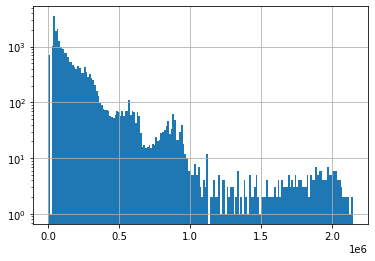

In [26]:
# Using the filtered plot from Stage 2 to reduce migraines (caused by the number of data points) slightly.
p2_state_hist = p2["Confirmed"].hist(bins="auto", log=True)

2) Recovered Cases:

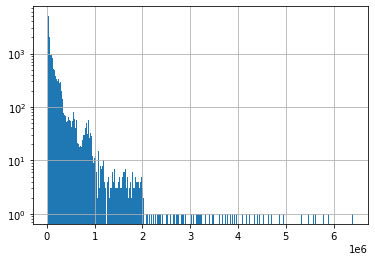

In [27]:
p2_chaos_hist = p2["Recovered"].hist(bins="auto", log=True)

3) Deaths:

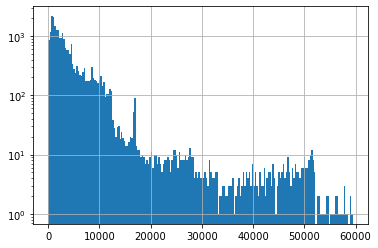

In [28]:
p2_balanced_hist = p2["Deaths"].hist(bins="auto", log=True)

#### 3.2.2 - Plots Within Plots

All three plots, but together now!

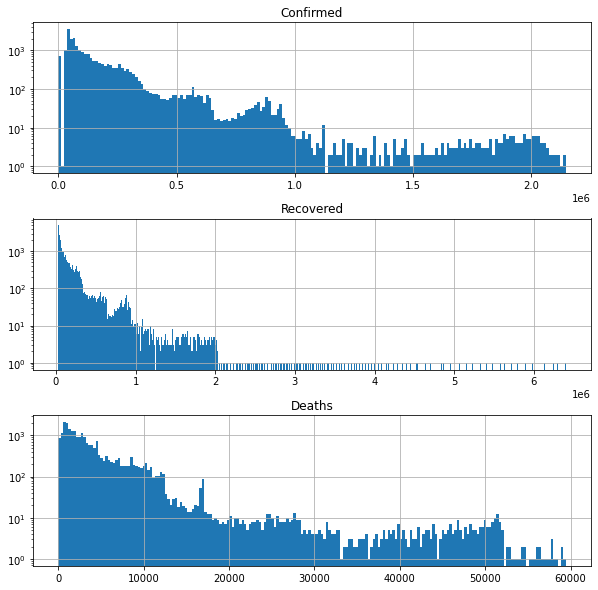

In [29]:
p2_grouped_hist = p2.hist(column=["Confirmed", "Recovered", "Deaths"],
                          bins="auto", layout=(3, 1), figsize=(10, 10), log=True)

#### 3.2.3 - Single-Line Graph

This is an attempt at graphing recovered cases over time. <br>
*It turns out that 20,000 data points don't make for a good line graph.*

<ipython-input-30-68ada921e99f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2["ObservationDate"] = pd.to_datetime(p2["ObservationDate"])
<ipython-input-30-68ada921e99f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2.sort_values(by="ObservationDate", ascending=True, inplace=True)


<AxesSubplot:xlabel='ObservationDate'>

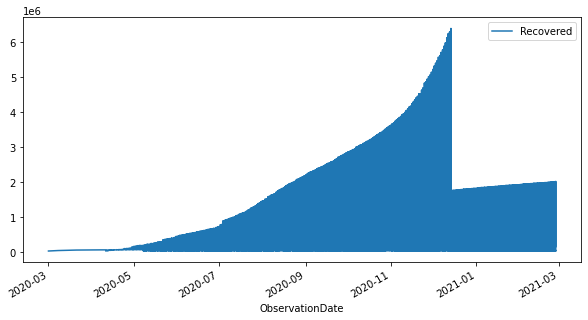

In [30]:
p2["ObservationDate"] = pd.to_datetime(p2["ObservationDate"])
p2.sort_values(by="ObservationDate", ascending=True, inplace=True)
p2.plot(x="ObservationDate", y="Recovered", figsize=(10,5))

#### 3.2.4 - Multi-Line Graph

Now with less data points! <br>
Creates a function to reduce redundant code in this section somewhat.


In [31]:
def aggravate(tmp_series, target):
    return tmp_series.aggregate({target:"last"}).groupby(["Country/Region"], as_index=False,
                                                         dropna=False).aggregate({target:"sum"})[target]

Creates a temporary *unsorted* dataframe for use with the "aggravate" function.

In [32]:
tmp_ser = df.groupby(["Country/Region", "Province/State"], as_index=False, dropna=False)

Creates a new dataframe (lg) which is filtered to both make the data more meaningful and reduce the number of datapoints.


In [33]:
lg = pd.DataFrame()
lg["Country"] = (tmp_ser.aggregate({"Confirmed":"last"}).groupby(["Country/Region"], as_index=False,dropna=False).
                 aggregate({"Confirmed":"sum"}))["Country/Region"]
lg["Confirmed"] = aggravate(tmp_ser, "Confirmed")
lg["Recovered"] = aggravate(tmp_ser, "Recovered")
lg["Deaths"] = aggravate(tmp_ser, "Deaths")

Creates a line graph out of the newly-filtered function using the number of confirmed cases as the x-axis.

Text(0.5, 100, '|----------?----------|')

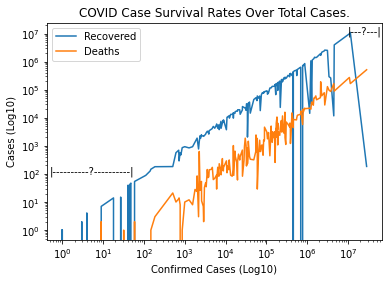

In [34]:
lg.sort_values(by="Confirmed", ascending=True, inplace=True)
lg.plot(
    'Confirmed', # X-Axis index
    title="COVID Case Survival Rates Over Total Cases.",
    ylabel="Cases (Log10)",
    xlabel="Confirmed Cases (Log10)",
    legend=True,
    loglog=True # Sets both axes to a logarithmic scale.
)

mp.pyplot.annotate('|---?---|', (10**7, 10**7))
mp.pyplot.annotate('|----------?----------|', (0.5, 100))

#### 3.2.5 - Bar Graph

Now with beautiful labels! <br>
Saves the artwork to a .png in the working folder.

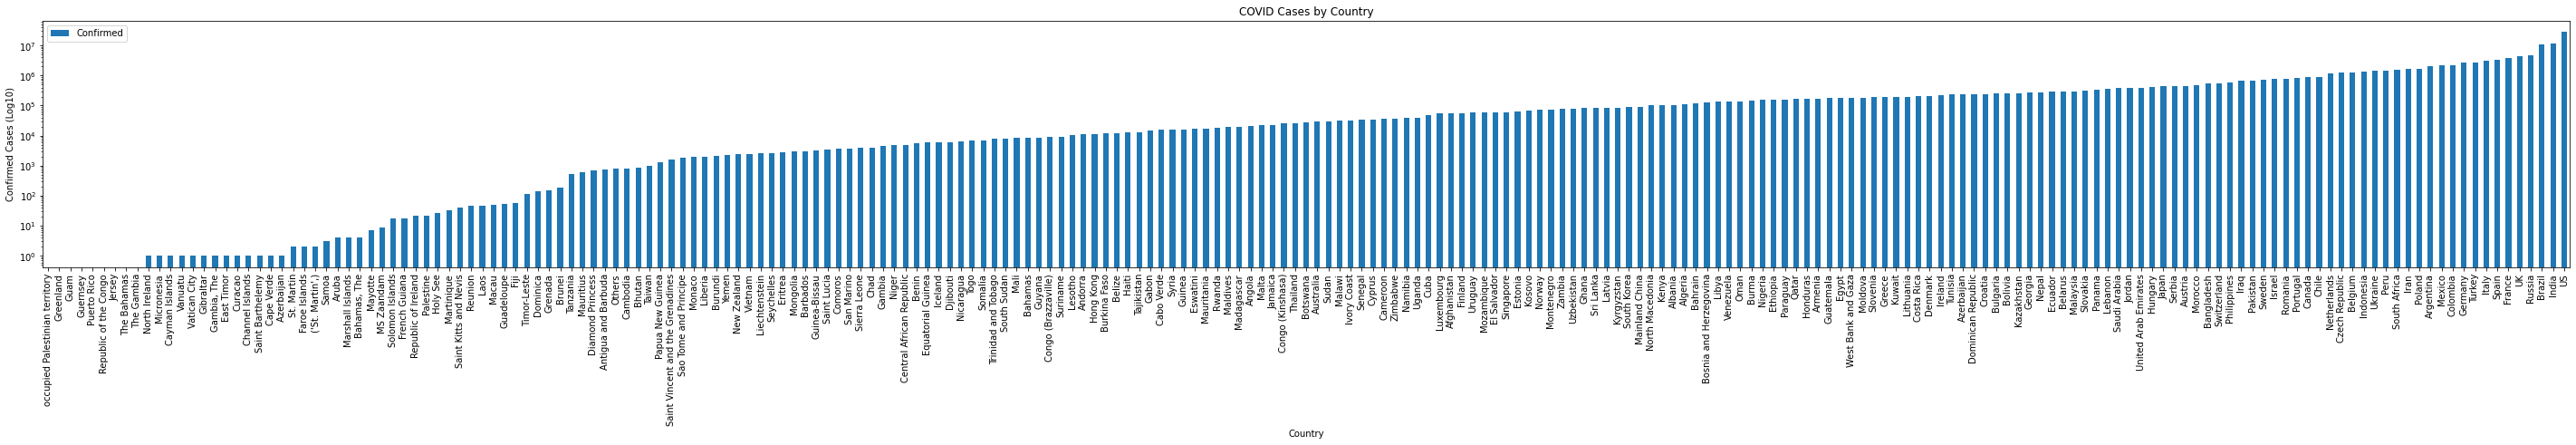

In [39]:
lg_bar = lg
lg_bar.set_index("Country")
lg_bar.plot.bar(
    "Country", "Confirmed", # X-Axis, Y-Axis
    title="COVID Cases by Country",
    ylabel="Confirmed Cases (Log10)",
    figsize=(50,5),
    legend=True,
    logy=True
)

mp.pyplot.savefig("not_modern_art.png")

## Stage 4 - Data Wrangling

### Part 4.1 - Hierarchical Indexing

#### Part 4.1.1 - .set_index()

Lorem Ipsum

In [44]:
p4 = df
p4.set_index("SNo")
p4.groupby("SNo", axis=1)
p4.sort_index()
print(p4)
p5 = p4.unstack(level=-1)
print(p5)

           SNo ObservationDate     Province/State  Country/Region  \
0            1      01/22/2020              Anhui  Mainland China   
1            2      01/22/2020            Beijing  Mainland China   
2            3      01/22/2020          Chongqing  Mainland China   
3            4      01/22/2020             Fujian  Mainland China   
4            5      01/22/2020              Gansu  Mainland China   
...        ...             ...                ...             ...   
236012  236013      02/27/2021  Zaporizhia Oblast         Ukraine   
236013  236014      02/27/2021            Zeeland     Netherlands   
236014  236015      02/27/2021           Zhejiang  Mainland China   
236015  236016      02/27/2021    Zhytomyr Oblast         Ukraine   
236016  236017      02/27/2021       Zuid-Holland     Netherlands   

                Last Update  Confirmed  Deaths  Recovered  \
0           1/22/2020 17:00        1.0     0.0        0.0   
1           1/22/2020 17:00       14.0     0.0   

#### Part 4.1.2 - .unstack()

Lorem Ipsum

In [ ]:
# Code goes here.

#### Part 4.1.3 - Summary Statistics

Lorem Ipsum

In [ ]:
# Code goes here.

#### Part 4.1.4 - .pivot()

Lorem Ipsum

In [ ]:
# Code goes here.

Explanation goes here.

#### Part 4.1.5 - .groupby() -> .unstack()

Lorem Ipsum

In [ ]:
# Code goes here.

Explanation goes here.

### Part 4.2 - Merge and Concat

#### Part 4.2.1a - Splitting the Dataset

Lorem Ipsum

In [ ]:
# Code goes here.

#### Part 4.2.1b - pd.concat()

Lorem Ipsum

In [ ]:
# Code goes here.

Explanation goes here.


#### Part 4.2.2 - pd.merge()


##### Part 4.2.2.1 - The "On" Parameters

Lorem Ipsum

In [ ]:
# Code goes here.

Explanation goes here.

##### Part 4.2.2.2 - The "How" Parameter

Lorem Ipsum

In [ ]:
# Code goes here.

Explanation goes here.

### Part 4.3 - Pivot Table and CrossTab

#### Part 4.3.1 - .pivot_table()

##### Part 4.3.1.1 - Replicating Hierarchical Indexing

Lorem Ipsum

In [ ]:
# Code goes here.


###### Part 4.3.1.2 - Again, with "margins=True"

Lorem Ipsum

In [ ]:
# Code goes here.

Explanation goes here.

###### Part 4.3.1.3 - Yet Again, but with "aggfunc="

Lorem Ipsum

In [ ]:
# Code goes here.

#### Part 4.3.2 - pd.crosstab()

Lorem Ipsum

In [ ]:
# Code goes here.

Explanation goes here.

### Part 4.4 - Screencast Video

*Coming Soon...*
